In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Постановка задачи

Имея информацию о составе [ШФЛУ](https://ru.wikipedia.org/wiki/%D0%A8%D0%B8%D1%80%D0%BE%D0%BA%D0%B0%D1%8F_%D1%84%D1%80%D0%B0%D0%BA%D1%86%D0%B8%D1%8F_%D0%BB%D1%91%D0%B3%D0%BA%D0%B8%D1%85_%D1%83%D0%B3%D0%BB%D0%B5%D0%B2%D0%BE%D0%B4%D0%BE%D1%80%D0%BE%D0%B4%D0%BE%D0%B2), скорости движения газа в начале и конце трубы предсказать состав ШФЛУ в конце трубопровода.

Состав газа меняется из-за воздействия внешних факторов, различия в скорости движения различных фракций и наличия дополнительных точек входа газа.

Точное знание о составе ШФЛУ поможет компании планировать загруженность оборудования.

Метрика - средний MAPE по всем таргетам

# Константы

In [2]:
data_path = 'data/'

features = ['A_rate', 'A_CH4', 'A_C2H6', 'A_C3H8', 'A_iC4H10', 'A_nC4H10',
            'A_iC5H12', 'A_nC5H12', 'A_C6H14', 'B_rate']

# Обзор имеющихся данных

In [3]:
train_features = pd.read_csv(data_path + 'train_features.csv')
test_features = pd.read_csv(data_path + 'test_features.csv')
train_targets = pd.read_csv(data_path + 'train_targets.csv')

## Количество наблюдений и признаки

In [7]:
train_features['timestamp'] = pd.to_datetime(train_features['timestamp'])
test_features['timestamp'] = pd.to_datetime(test_features['timestamp'])
train_targets['timestamp'] = pd.to_datetime(train_targets['timestamp'])

1. train_features, test_features - тренировочные и тестовые признаки
2. train_targets - тренировочные таргеты

In [4]:
print('Shape of train features:', train_features.shape)
train_features.head()

Shape of train features: (5808, 11)


,timestamp,A_rate,A_CH4,A_C2H6,A_C3H8,A_iC4H10,A_nC4H10,A_iC5H12,A_nC5H12,A_C6H14,B_rate
0,2020-01-01 00:00:00,70.855017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.982789
1,2020-01-01 00:30:00,70.826582,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.965098
2,2020-01-01 01:00:00,70.809637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.867409
3,2020-01-01 01:30:00,69.994748,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.839126
4,2020-01-01 02:00:00,70.072762,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.336921


In [5]:
print('Shape of test features:', test_features.shape)
test_features.head()

Shape of test features: (3984, 11)


,timestamp,A_rate,A_CH4,A_C2H6,A_C3H8,A_iC4H10,A_nC4H10,A_iC5H12,A_nC5H12,A_C6H14,B_rate
0,2020-05-01 00:00:00,71.428342,0.267832,5.135159,36.816480,16.632260,24.062587,5.696004,4.939430,6.395286,74.273009
1,2020-05-01 00:30:00,70.925118,0.268464,5.149646,36.869023,16.651870,24.069800,5.676384,4.911872,6.346957,74.061833
2,2020-05-01 01:00:00,70.991719,0.270641,5.154615,37.074965,16.710967,24.106152,5.574873,4.808516,6.242636,73.856268
3,2020-05-01 01:30:00,70.972406,0.275241,5.230661,37.384180,16.683337,24.021993,5.514843,4.730887,6.101647,73.750744
4,2020-05-01 02:00:00,70.980078,0.275062,5.241437,37.448587,16.663863,24.003237,5.524898,4.728882,6.057119,73.698447


In [6]:
print('Shape of train targets:', train_targets.shape)
train_targets.head()

Shape of train targets: (5808, 5)


,timestamp,B_C2H6,B_C3H8,B_iC4H10,B_nC4H10
0,2020-01-01 00:00:00,4.561979,39.015486,17.250740,24.301793
1,2020-01-01 00:30:00,4.550741,39.048915,17.229506,24.257461
2,2020-01-01 01:00:00,4.506793,38.766378,17.171621,24.236298
3,2020-01-01 01:30:00,4.584963,39.069360,17.218521,24.149843
4,2020-01-01 02:00:00,4.607483,38.817579,17.108668,24.049510


Имеется 5808 наблюдений в тренировочной части датасета и 3984 наблюдения в тестовой части. 

Среди признаков имеется временная отметка наблюдения, скорость потока газа в точке A и точке B, а таже состав ШФЛУ в точке A

Таргеты - процентное содержание некоторых фракций в точке B.

Частота наблюдений - каждые 30 минут

## Ряды признаков и таргетов

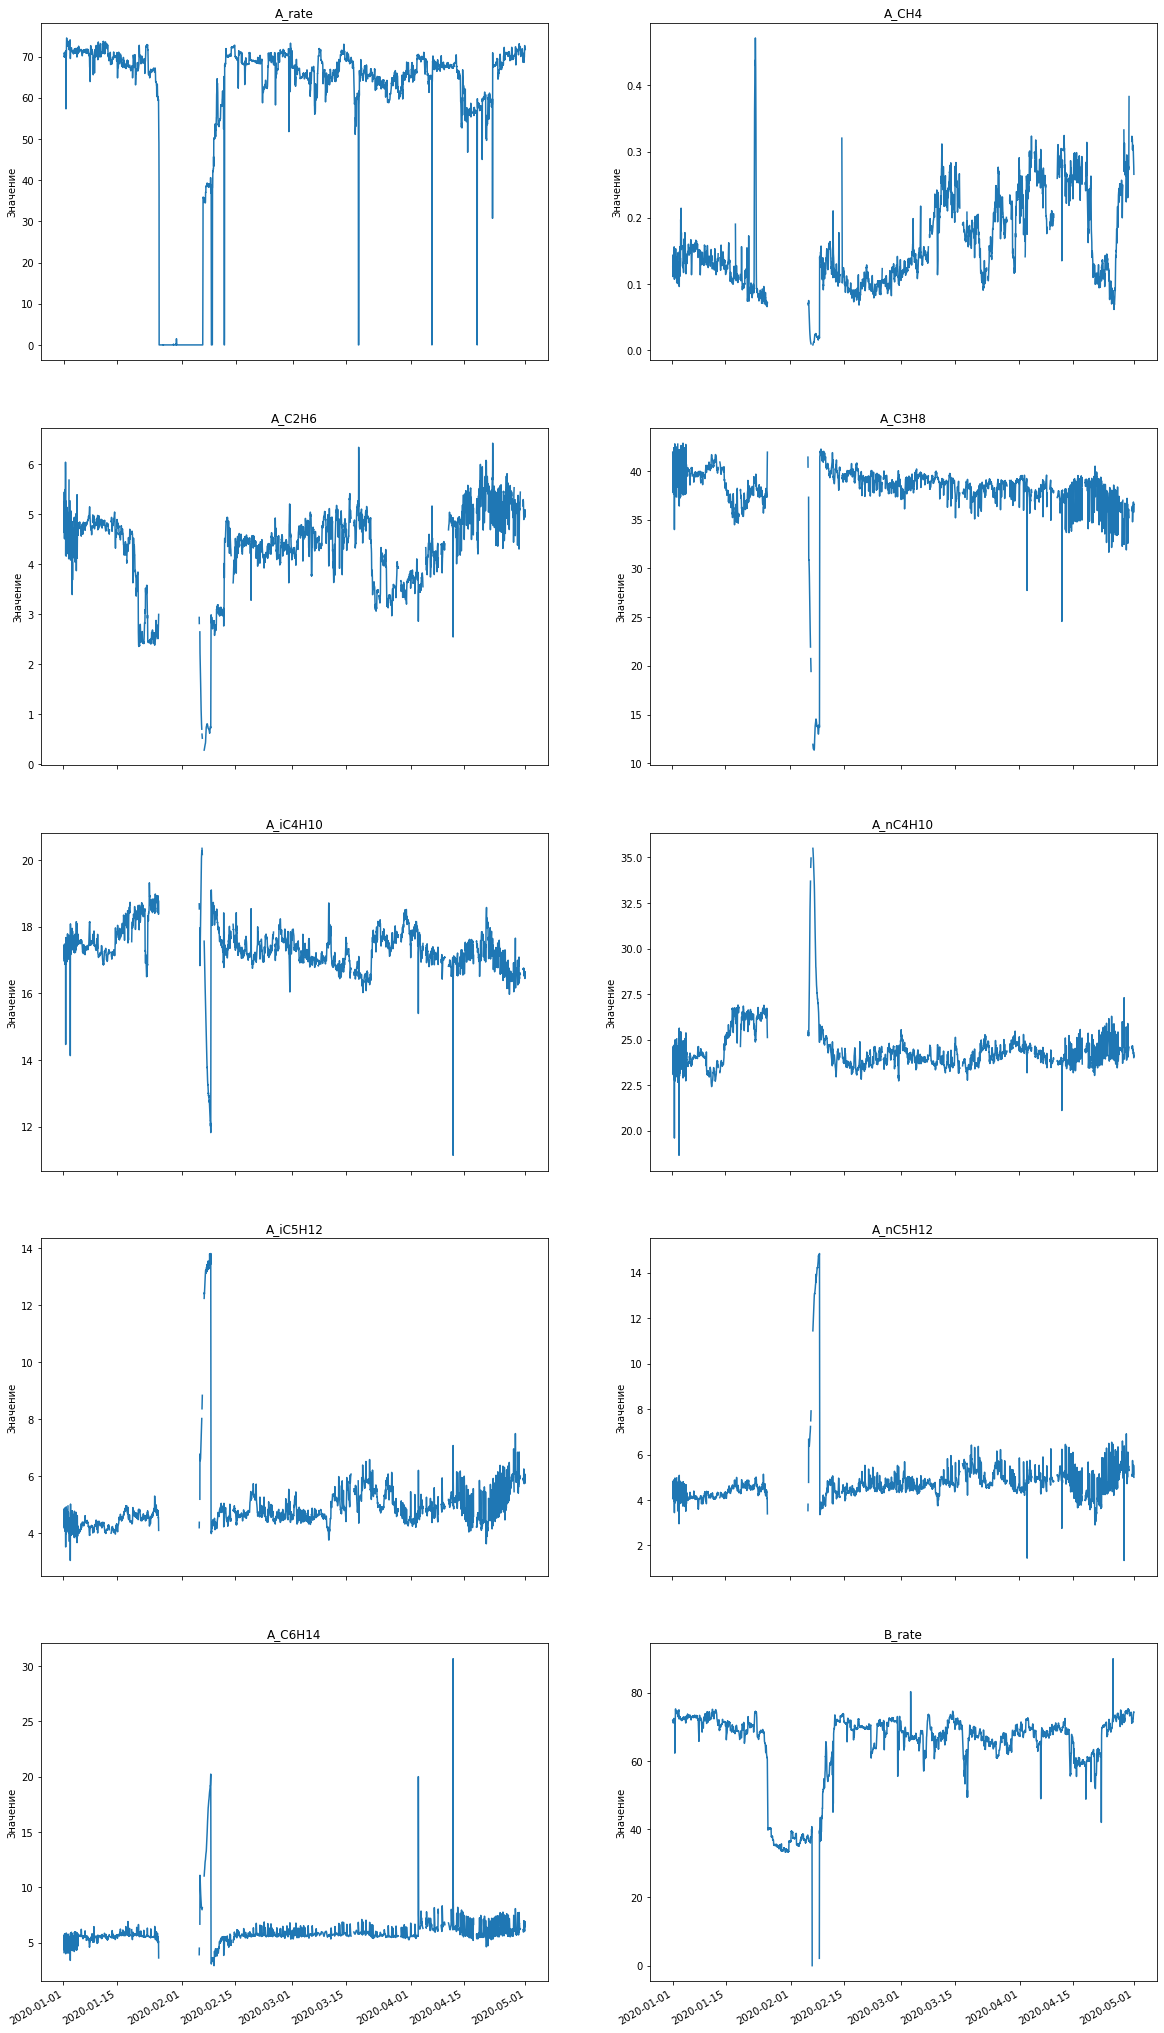

In [8]:
fig, ax = plt.subplots(5, 2, figsize = (20, 40))
fig.autofmt_xdate()
row = 0
col = 0
for feature in features:
    _ = sns.lineplot(x = 'timestamp', 
                     y = feature,
                     data = train_features,
                     ax = ax[row][col])
    ax[row][col].set_xlabel('')
    ax[row][col].set_ylabel('Значение')
    ax[row][col].set_title(feature)
    if col == 1:
        row = row+1
        col = 0
    else:
        col = col+1

In [66]:
test_features

,timestamp,A_rate,A_CH4,A_C2H6,A_C3H8,A_iC4H10,A_nC4H10,A_iC5H12,A_nC5H12,A_C6H14,B_rate
0,2020-05-01 00:00:00,71.428342,0.267832,5.135159,36.816480,16.632260,24.062587,5.696004,4.939430,6.395286,74.273009
1,2020-05-01 00:30:00,70.925118,0.268464,5.149646,36.869023,16.651870,24.069800,5.676384,4.911872,6.346957,74.061833
2,2020-05-01 01:00:00,70.991719,0.270641,5.154615,37.074965,16.710967,24.106152,5.574873,4.808516,6.242636,73.856268
3,2020-05-01 01:30:00,70.972406,0.275241,5.230661,37.384180,16.683337,24.021993,5.514843,4.730887,6.101647,73.750744
4,2020-05-01 02:00:00,70.980078,0.275062,5.241437,37.448587,16.663863,24.003237,5.524898,4.728882,6.057119,73.698447
...,...,...,...,...,...,...,...,...,...,...,...
3979,2020-07-22 21:30:00,72.600912,0.120985,4.328092,40.875930,17.741460,24.098520,4.469224,3.619095,4.686205,75.486026
3980,2020-07-22 22:00:00,72.107049,0.110734,4.013567,38.871418,17.449352,24.049532,4.770699,3.988215,6.689777,75.370451
3981,2020-07-22 22:30:00,71.805799,0.111535,4.041506,39.794323,17.635380,24.169473,4.613603,3.790651,5.785216,74.985878
3982,2020-07-22 23:00:00,72.112046,0.119362,4.131432,40.461503,17.758833,24.211013,4.504242,3.657459,5.094626,74.766867


<AxesSubplot:ylabel='B_rate'>

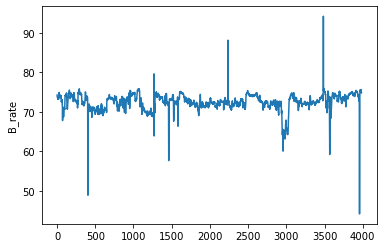

In [70]:
sns.lineplot(x = range(0, len(test_features)), y = test_features['B_rate'])

<AxesSubplot:ylabel='A_rate'>

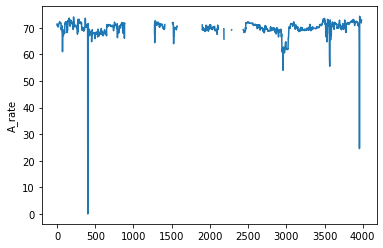

In [71]:
sns.lineplot(x = range(0, len(test_features)), y = test_features['A_rate'])

Видно, что примерно с 15 января по 15 февраля произошел какой-то сбой: состав многих фракций неизвестен или испытывал сильные колебания. Такая же ситуация наблюдается примерно с 15 апреля.

Отброшу данные до 15 феврала, потому что в этот период наблюдаются аномалии в данных. При этом после этих аномалий паттерн в данных мог измениться, поэтому данные без пропусков и аномалий (примерно с 1 январа до 20 января) я также отброшу.

Пропуски в данных заполнялись последним известным значением (то есть обычный forward fill). Были идеи заполнять пропуски скользящим средним и т.д., но они не принесли результатов.

## Разбиение тренировочной части выборки

На основе данной информации я построил разбиение тренировочной выборки следующим образом:

Fold 1: 15-02-2020 - 01-03-2020  

Fold 2: 01-03-2020 - 15-03-2020  

Fold 3: 15-03-2020 - 31-03-2020 

Fold 4: 31-03-2020 - 15-04-2020 

(использовалось в качестве локальной тестовой части. То есть результат на этом фолде не входит в подсчет среднего. Результаты на этом фолде были всегда хуже, чем на других, т.к. по графикам видно, что к концу этого фолда начинается аномалия.)

С помощью этих фолдов было построено 2 кросс валидации:
1. Обучаем модель на всех фолдах до n, тестируем на фолде n.

Например, обучаем модель на Fold 1, Fold 2, тестируем на Fold 3.

2. Обучаем модель на Fold 1, тестируем на всех остальных фолдах.

Первый вариант кросс валидации показал плохие результаты. Также не очень понятно, на какой части выборки обучать итоговую модель для предсказания, ведь в последние полмесяца тренировочное части происходили какие-то аномалии, что вносило в модель смещение.

Поэтому далее все результаты приведены для второго варианта кросс валидации: обучаем модель на промежутке 15-02-2020 - 01-03-2020), тестируем на остальных фолдах (усредняем результаты и оцениваем качество модели по среднему MAPE на всех валидационных фолдах). Дополнительно контролировалась дисперсия MAPE на фолдах. Если дисперсия маленькая - то модель одинаково ошибается на всех фолдах, то есть она устойчива. Дисперсия почти на всех моделях была маленькая, поэтому далее этот показатель не рассматривается.

## Смещение признаков

Т.к. газ движется с одного конца трубы в другой, то разумно предположить, что состав газа на конце трубы в момент времени X должен быть похож на состав газа в начале трубы в момент X - t, где t - время, за которое газ проходит из начала трубы в конец.

Т.к. информации о длине трубы не было предоставлено, то это самое время t я выяснил с помощью графиков

Рассмотрим промежуток с 2020-02-15 23:30:00 до 2020-03-28 23:30:00

### C2H6

Сместим информацию о составе газа в конце трубы на 200 наблюдений назад.

<ipython-input-13-b413927b1763>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['B_C2H6'] = data['B_C2H6'].shift(-200)


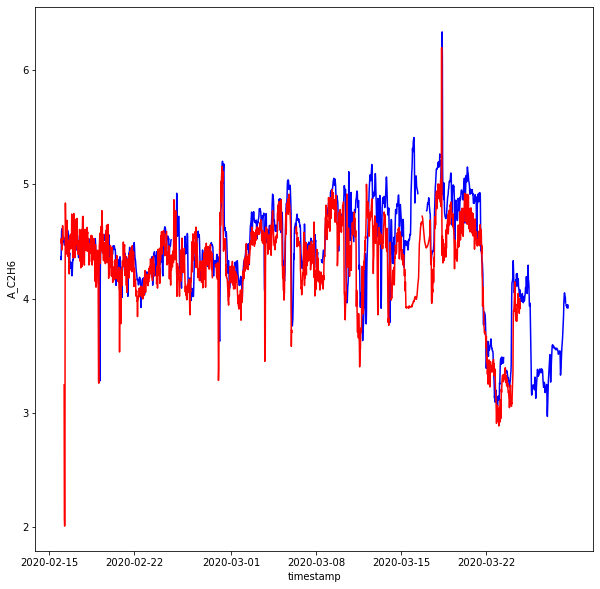

In [13]:
plt.figure(figsize = (10, 10))
_ = sns.lineplot(x = 'timestamp', 
                 y = 'A_C2H6', 
                 data = train_features[(train_features['timestamp']>= pd.to_datetime('2020-02-15 23:30:00')) & 
                                       (train_features['timestamp']<= pd.to_datetime('2020-03-28 23:30:00'))], 
                 color = 'blue')
data = train_targets[(train_targets['timestamp']>= pd.to_datetime('2020-02-15 23:30:00')) & 
                                      (train_targets['timestamp']<= pd.to_datetime('2020-03-28 23:30:00'))]
data['B_C2H6'] = data['B_C2H6'].shift(-200)
_ = sns.lineplot(x = 'timestamp', 
                 y = 'B_C2H6', 
                 data = data, 
                 color = 'red')

Видно, что при смещение информации о доле C2H6 в конце трубы на 200 наблюдений (то есть 200*30 = 6000 минут) получается почти идеально совпадение с долей C2H6 в начале трубы. Присутствует небольшое вертикальное смещение и шум (скорее всего это происходит из-за наличие по пути трубопровода врезки трубы с ШФЛУ другого состава).

### C3H8

<ipython-input-20-5480e9038439>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['B_C3H8'] = data['B_C3H8'].shift(-200)


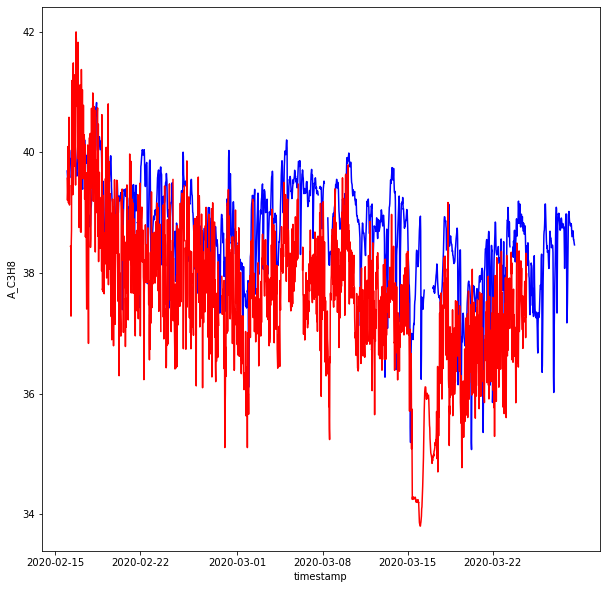

In [20]:
#C3H8
plt.figure(figsize = (10, 10))
_ = sns.lineplot(x = 'timestamp', 
                 y = 'A_C3H8', 
                 data = train_features[(train_features['timestamp']>= pd.to_datetime('2020-02-15 23:30:00')) & 
                                       (train_features['timestamp']<= pd.to_datetime('2020-03-28 23:30:00'))], 
                 color = 'blue')

data = train_targets[(train_targets['timestamp']>= pd.to_datetime('2020-02-15 23:30:00')) & 
                                      (train_targets['timestamp']<= pd.to_datetime('2020-03-28 23:30:00'))]
data['B_C3H8'] = data['B_C3H8'].shift(-200)
_ = sns.lineplot(x = 'timestamp', 
                 y = 'B_C3H8', 
                 data = data, 
                 color = 'red')

### iC4H10

<ipython-input-19-be97048fef58>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['B_iC4H10'] = data['B_iC4H10'].shift(-190)


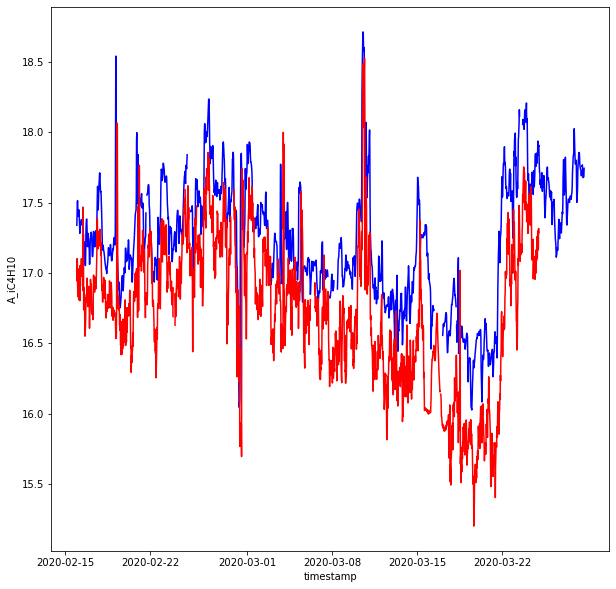

In [19]:
plt.figure(figsize = (10, 10))
_ = sns.lineplot(x = 'timestamp', 
                 y = 'A_iC4H10', 
                 data = train_features[(train_features['timestamp']>= pd.to_datetime('2020-02-15 23:30:00')) & 
                                       (train_features['timestamp']<= pd.to_datetime('2020-03-28 23:30:00'))], 
                 color = 'blue')
data = train_targets[(train_targets['timestamp']>= pd.to_datetime('2020-02-15 23:30:00')) & 
                                      (train_targets['timestamp']<= pd.to_datetime('2020-03-28 23:30:00'))]
data['B_iC4H10'] = data['B_iC4H10'].shift(-190)
_ = sns.lineplot(x = 'timestamp', 
                 y = 'B_iC4H10', 
                 data = data, 
                 color = 'red')

### nC4H10

<ipython-input-17-6123fc08a771>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['B_nC4H10'] = data['B_nC4H10'].shift(-200)


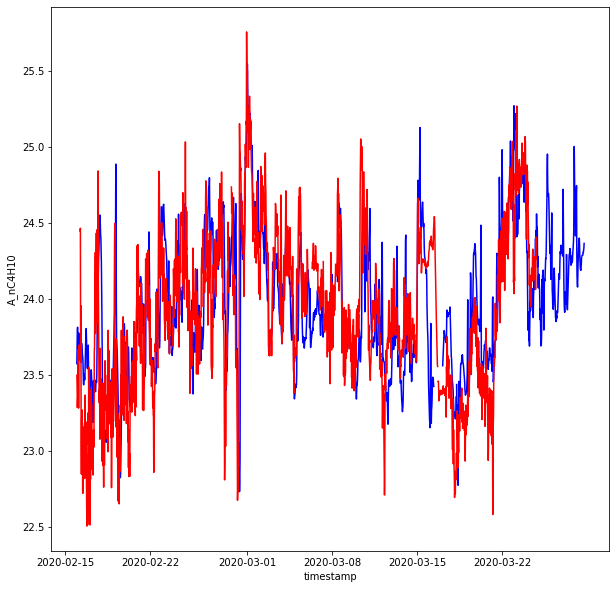

In [17]:
plt.figure(figsize = (10, 10))
_ = sns.lineplot(x = 'timestamp', 
                 y = 'A_nC4H10', 
                 data = train_features[(train_features['timestamp']>= pd.to_datetime('2020-02-15 23:30:00')) & 
                                       (train_features['timestamp']<= pd.to_datetime('2020-03-28 23:30:00'))], 
                 color = 'blue')
data = train_targets[(train_targets['timestamp']>= pd.to_datetime('2020-02-15 23:30:00')) & 
                                      (train_targets['timestamp']<= pd.to_datetime('2020-03-28 23:30:00'))]
data['B_nC4H10'] = data['B_nC4H10'].shift(-200)
_ = sns.lineplot(x = 'timestamp', 
                 y = 'B_nC4H10', 
                 data = data, 
                 color = 'red')

Видно, что все таргеты являются смещением доли соответствующего газа в начале трубы на 200 наблюдений.

# Модели

Было построено несколько моделей
1. Нейронные сети (как полносвязные, так и рекуррентные (LSTM))
2. Градиентный бустинг над деревьями решений (lightgbm)
3. Стохастический градиент спуск над линейной регрессией, настроенный таким образом, чтобы минимизировать MAPE.

## Нейронные сети

Нейросети строились с помощью pytorch lightning.

Используемые нейронные сети:

1. LSTM (4 выхода - по одному для каждого таргета).

2. Полносвязная нейронная сеть (4 выхода - по одному для каждого таргета).

В каждой нейронной сети с помощью библиотеки optuna подбирались гиперпараметры (количество нейронов в скрытых слоях, функции активации, learning rate, drop rate (вероятность пропуска нейрона в слоях dropout (для регуляризации, чтобы сеть не переобучалась)), weight decay, оптимизатор (AdamW, Adamgrad и т.д.), функции потерь (MSE, MAPE, MAE)), длина последовательности (для LSTM), размер батча (сколько сэмплов за раз подается в нейронную сеть).

Также одновременно подбирались параметры для обработки датасета: размер сдвига (на сколько сдвинуть процентное содержание газа в точке A), длина скользящего окна для добавления скользящего среднего признаков (в некоторых моделях).

Т.к. данных относительно немного (5808 изначальных наблюдений на train части), то удалось перебрать достаточно большое количество архитектур.

Лучший результат работы LSTM модели: \
mean MAPE на CV: 0.04079780727624893. \
Public leaderboard: 3.0315. \
Private leaderboard: 4.2426

Лучший результат полносвязной нейронной сети (4 выхода - по одному для каждого таргета): \
mean MAPE на CV: 0.03998283017426729. \
Public leaderboard: 3.125. \
Private leaderboard: 4.2550

Также были попытки построить отдельную нейронную сеть для каждого таргета, однако результаты не смогли достигнуть результатов 1 нейронной сети для всех таргетов, а построить несколько моделей значительно сложнее, поэтому эта идея дальше не развивалась.

В целом нейронные сети дали хороший результат в середине соревнования, однако, перебрав большое множество параметров улучшить результат не получилось, поэтому я решил перейти к другим моделям.

Скорее всего, нейронная сеть не смогла дать лучший результат из-за того, что она слишком чувствительна к выбросам.

## Градиентный бустинг над деревьями решений

В качестве библиотеки для построения градиентного бустинга над деревьями использовался lightgbm.
Параметры подбирались с помощью библиотеки optuna: learning rate, bagging fraction (какую долю сэмплов использовать при построении каждого дерева), feature fraction (сколько фичей использовать для построения каждого дерева), num leaves (максимально количество листьев в каждом дереве), min child samples (минимальное количество сэмплов в каждом листе дерева), objective (какую функцию минимизировать: MAE, MAPE, Huber loss и тд).

Для датасета также подбирались размер сдвига, размер сдвига для каждой фичи отдельно (была гипотеза о том, что вещества движутся с разной скоростью, поэтому надо учитывать процентное содержание каждого вещества разное количество наблюдений назад).

Лучший результат lightgbm: \
mean MAPE на CV: 0.03578154874155. \
Public leaderboard: 2.8630. \
Private leaderboard: 4.1626

Градиентный бустинг над деревьями дал результат лучше, чем нейронные сети. Скорее всего так получилось из-за того, что деревья решений достаточно устойчивы к выбросам.

Т.к. в данных видна четкая тенденция (сдвиг состава газа в точке A повторяет состав газа в точке B), то я решил перейти к еще более простым моделям.

## Градиентный бустинг над линейными моделями

Т.к. на графику взаимосвязь кажется достаточно простой, то я решил попробовать использовать линейные модели.

По графику видно, что доля вещества в точке B очень похожа на долю этого же вещества в точке A примерно 200 наблюдений назад. Поэтому была ипользована линейная модель, использующая в качестве признаков долю вещества в точке A в период от 180 до 220 наблюдений назад (точный сдвиг подбирался как и другие гиперпараметры).

Была использована SGD linear model из sklearn, настроенная таким образом, чтобы минимизировать MAE:\
1. Функция потерь: epsilon_insensitive
2. epsilon: 0
3. tol: 1e-5 (если за 5 шагов градиентного спуска Loss не уменьшается на эту величину, то тренировка останавливается)

Остальные параметры по умолчанию

[Подробнее про функцию потерь и epsilon](https://scikit-learn.org/stable/modules/sgd.html#sgd-mathematical-formulation)

Лучшие результаты и соответствующие параметры:\
1. Для модели, предсказывающей nC4H10:\
Сдвиг A_nC4H10 на 198 наблюдений вперед.\
Лучший результат на CV: 0.01102263996442774
2. Для модели, предсказывающей iC4H10\
Сдвиг A_iC4H10 на 198 наблюдений вперед\
Лучший результат на CV: 0.013200559025136269
3. Для модели, предсказывающей C3H8\
Сдвиг A_C3H8 на 197 наблюдений вперед\
Лучший результат на CV: 0.01902337550250795
4. Для модели, предсказывающей C2H6\
Сдвиг A_C2H6 на 195 наблюдений вперед\
Лучший результат на CV: 0.04703402989345981

То есть средний MAPE по таргетам на всех фолдах: 0.022570151096382943\
Public leaderboard: 2.3698\
Private leaderboard: 3.7455\

Данное решение заняло на приватном лидерборде ~78место/206. 

После совместного развития идеи со сдвигами моему сокоманднику удалось улучшить данное решение. Добавив в модель информацию о расходе ШФЛУ в двух точках ему удалось получить следующий результат: public leaderboard: 1.6077, private leaderboard 2.6958 (6 место).